In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 26})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
from lmfit import Model,Minimizer
import corner
import numdifftools
from scipy.ndimage import interpolation

In [2]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler

Using TensorFlow backend.


In [287]:
def linear(arr,m,c):
    return m*arr + c

def get_s2n(spectrum):
    bit = spectrum[1200:1400]
    lambit = lamgrid[1200:1400]
    p,c = curve_fit(linear,lambit,bit)
    res = bit - linear(lambit,p[0],p[1])
    s2n = np.mean(bit)**2 / np.var(res)
    return s2n

In [289]:
wdtable = Table.read('wdtable.fits')
searchparameter = list(wdtable['specnames'])
bprps = [];
gs = [];
## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

s2ns = [];
for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    s2ns.append(get_s2n(flux))

100%|██████████| 11075/11075 [13:06<00:00, 14.08it/s]


In [291]:
s2ns = np.log10(s2ns)

In [292]:
wdtable['S2N'] = s2ns

In [293]:
wdtable.write('wdtable_sn.fits')

W0731 14:22:18.178479 47635386279232 logger.py:200] UnitsWarning: ''electron'.s**-1' did not parse as fits unit: At col 0, Unit ''electron'' not supported by the FITS standard. 
W0731 14:22:18.194534 47635386279232 logger.py:200] UnitsWarning: 'log(cm.s**-2)' did not parse as fits unit: 'log' is not a recognized function
W0731 14:22:18.200927 47635386279232 logger.py:200] UnitsWarning: 'dex' did not parse as fits unit: At col 0, Unit 'dex' not supported by the FITS standard. 
W0731 14:22:18.221477 47635386279232 logger.py:200] UnitsWarning: 'Msun' did not parse as fits unit: At col 0, Unit 'Msun' not supported by the FITS standard. Did you mean Sun?


In [180]:
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];
good = (
    (wdtable['centre_beta'] < hbeta + 5)*
    (wdtable['centre_beta'] > hbeta - 5)*
    (wdtable['centre_alpha'] > halpha - 5)*
    (wdtable['centre_alpha'] < halpha + 5) * 
    (~np.isnan(wdtable['loggH']))*
    (~np.isnan(wdtable['TeffH']))*
    (wdtable['TeffH'] > 13000) * 
    (wdtable['TeffH'] < 80000) * 
    (wdtable['subclass'] == 'WD')[:,0].data
    #(wdtable['s2n'] < 1)
)
wdtable = wdtable[good]
len(wdtable)

def rvcorr(spectrum):
    lamgrid = np.arange(4000,8000)
    coremask = (lamgrid == 6565)+(lamgrid == 4863)+(lamgrid == 4342)+(lamgrid == 4103)
    coremask = coremask.astype(int)
    trans = np.argmax(np.correlate(1-spectrum,coremask,mode='full'))-4000
    if trans > 5:
        trans = 5;
    elif trans < 5:
        trans = -5;
    else:
        ;
    shiftedspec = interpolation.shift(spectrum,-trans,cval=1)
    return shiftedspec

searchparameter = list(wdtable['specnames'])
bprps = [];
gs = [];
## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]
s2ns = [];
from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)

for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    
    s2n = get_s2n(flux)
    s2ns.append(s2n)
    if np.log10(s2n) < 2.5:
        continue;
    spectra.append(flux)
    TeffHs.append(wdtable[wdtable['specnames']==specname[:-5]]['TeffH'][0])
    loggHs.append(wdtable[wdtable['specnames']==specname[:-5]]['loggH'][0])
    bprps.append(wdtable[wdtable['specnames']==specname[:-5]]['bp_rp'][0])
    gs.append(wdtable[wdtable['specnames']==specname[:-5]]['abs_g'][0])
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)

100%|██████████| 1518/1518 [02:19<00:00, 10.91it/s]


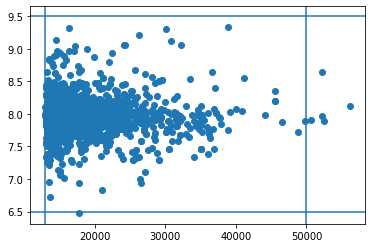

In [182]:
plt.scatter(TeffHs,loggHs)
plt.axhline(6.5)
plt.axhline(9.5)
plt.axvline(13000)
plt.axvline(50000)

(array([  1.,   3.,  34., 162., 356., 408., 335., 165.,  38.,  16.]),
 array([1.0949732 , 1.41230063, 1.72962805, 2.04695548, 2.36428291,
        2.68161034, 2.99893777, 3.3162652 , 3.63359262, 3.95092005,
        4.26824748]),
 <a list of 10 Patch objects>)

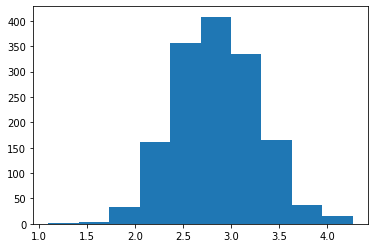

In [186]:
lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [187]:
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)

100%|██████████| 1518/1518 [00:03<00:00, 385.03it/s]


1518

In [188]:
sc = StandardScaler()

X = sc.fit_transform(np.stack((TeffHs,loggHs)).transpose())
t = normspec

In [189]:
X_train,X_test,y_train,y_test = train_test_split(X,t,test_size=0.1)

In [227]:
def v_mse(y_true,y_pred):
    return K.mean(K.sum((1e5*y_pred-1e5*y_true)**2))

import keras
def generator():
    x = Input(shape=X[0].shape)
    y = Dense(10,activation='sigmoid')(x)
    y = Dropout(0.5)(y)
    y = Dense(10,activation='sigmoid')(y)
    y = Dropout(0.5)(y)
    out = Dense(3000,activation = 'linear')(y)
    
    model = keras.Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.01), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model

In [228]:
model = generator()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                30        
_________________________________________________________________
dropout_9 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 3000)              33000     
Total params: 33,140
Trainable params: 33,140
Non-trainable params: 0
_________________________________________________________________
None


In [265]:
epoch = 5000
batch = len(X_train)

history = model.fit(X_train,y_train,epochs=epoch,verbose=1,batch_size=batch,validation_data = (X_test,y_test))

Train on 1366 samples, validate on 152 samples
Epoch 1/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0072 - mean_absolute_percentage_error: 9834.1641 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4216
Epoch 2/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9909.9951 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4220
Epoch 3/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9850.7871 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4228
Epoch 4/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9793.2295 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4233
Epoch 5/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0072 - mean_absolute_percentage_error: 9934.5859 - val_loss: 0.0037 - val_mean_absolute_percenta

Epoch 43/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9907.6299 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4266
Epoch 44/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9975.4844 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4256
Epoch 45/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9941.4893 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4249
Epoch 46/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0072 - mean_absolute_percentage_error: 9793.7119 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4244
Epoch 47/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9878.8672 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4238
Epoch 48/5000
1366/1366 [

Epoch 85/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9874.6387 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4240
Epoch 86/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9918.0381 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4231
Epoch 87/5000
1366/1366 [==============================] - 0s 41us/step - loss: 0.0072 - mean_absolute_percentage_error: 10011.5723 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4225
Epoch 88/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9869.1689 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4217
Epoch 89/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9970.8857 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4214
Epoch 90/5000
1366/1366 

Epoch 127/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9854.9961 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4239
Epoch 128/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9844.7266 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4234
Epoch 129/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9872.0986 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4228
Epoch 130/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9945.1152 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4221
Epoch 131/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9927.1719 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4216
Epoch 132/5000
1366/

Epoch 169/5000
1366/1366 [==============================] - 0s 47us/step - loss: 0.0072 - mean_absolute_percentage_error: 9846.4619 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4270
Epoch 170/5000
1366/1366 [==============================] - 0s 42us/step - loss: 0.0072 - mean_absolute_percentage_error: 9986.3867 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4261
Epoch 171/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9947.4658 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4255
Epoch 172/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9847.7354 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4247
Epoch 173/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9879.4707 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4236
Epoch 174/5000
1366/

Epoch 211/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9916.5234 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4300
Epoch 212/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9870.8145 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4298
Epoch 213/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9849.1855 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4291
Epoch 214/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9891.1523 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4284
Epoch 215/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9886.8457 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4271
Epoch 216/5000
1366/

Epoch 253/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9832.4746 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4268
Epoch 254/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9792.3086 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4267
Epoch 255/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 10056.6396 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4262
Epoch 256/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9795.2158 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4244
Epoch 257/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9971.2979 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4220
Epoch 258/5000
1366

Epoch 295/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9961.2500 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4211
Epoch 296/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9892.6660 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4214
Epoch 297/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9866.4648 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4217
Epoch 298/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9952.1094 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4224
Epoch 299/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9923.0283 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4239
Epoch 300/5000
1366/

Epoch 337/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9861.1182 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4249
Epoch 338/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 10052.1699 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4253
Epoch 339/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9893.6465 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4252
Epoch 340/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 10039.1670 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4255
Epoch 341/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9865.1006 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4255
Epoch 342/5000
136

Epoch 379/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9885.8857 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4287
Epoch 380/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9931.6367 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4294
Epoch 381/5000
1366/1366 [==============================] - 0s 48us/step - loss: 0.0072 - mean_absolute_percentage_error: 9786.6562 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4290
Epoch 382/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9841.7705 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4274
Epoch 383/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9833.4590 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4253
Epoch 384/5000
1366/

Epoch 421/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9981.5127 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4230
Epoch 422/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9855.4053 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4235
Epoch 423/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9796.6807 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4232
Epoch 424/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9884.6826 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4227
Epoch 425/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9998.8145 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4217
Epoch 426/5000
1366/

Epoch 463/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9872.6475 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4185
Epoch 464/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9912.8428 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4190
Epoch 465/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9812.0645 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4186
Epoch 466/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 10019.7598 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4185
Epoch 467/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9937.9980 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4186
Epoch 468/5000
1366

Epoch 505/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9886.4902 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4241
Epoch 506/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 10003.2588 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4239
Epoch 507/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0072 - mean_absolute_percentage_error: 9934.4707 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4236
Epoch 508/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9982.9141 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4235
Epoch 509/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9947.0010 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4225
Epoch 510/5000
1366

Epoch 547/5000
1366/1366 [==============================] - 0s 46us/step - loss: 0.0072 - mean_absolute_percentage_error: 9901.9678 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4286
Epoch 548/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9897.6855 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4269
Epoch 549/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9943.5898 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4251
Epoch 550/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9890.9795 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4234
Epoch 551/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9824.9346 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4217
Epoch 552/5000
1366/

Epoch 589/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9910.4375 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4249
Epoch 590/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9856.8076 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4253
Epoch 591/5000
1366/1366 [==============================] - 0s 44us/step - loss: 0.0072 - mean_absolute_percentage_error: 9864.0244 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4246
Epoch 592/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9800.3652 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4239
Epoch 593/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9945.8105 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4236
Epoch 594/5000
1366/

Epoch 631/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9858.4873 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4208
Epoch 632/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9784.0430 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4194
Epoch 633/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9806.0205 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4175
Epoch 634/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9886.6367 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4159
Epoch 635/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9850.1006 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4148
Epoch 636/5000
1366/

Epoch 673/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9854.9307 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4233
Epoch 674/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9809.1182 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4235
Epoch 675/5000
1366/1366 [==============================] - 0s 47us/step - loss: 0.0072 - mean_absolute_percentage_error: 10006.6465 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4236
Epoch 676/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9875.4717 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4229
Epoch 677/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 10031.5986 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4218
Epoch 678/5000
136

Epoch 715/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9990.4756 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4189
Epoch 716/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9837.5684 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4190
Epoch 717/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9871.6582 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4197
Epoch 718/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9963.9170 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4205
Epoch 719/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9840.9639 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4209
Epoch 720/5000
1366/

Epoch 757/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9853.5449 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4217
Epoch 758/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9898.4971 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4204
Epoch 759/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9824.7217 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4188
Epoch 760/5000
1366/1366 [==============================] - 0s 42us/step - loss: 0.0072 - mean_absolute_percentage_error: 10090.1836 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4172
Epoch 761/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 10083.5947 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4158
Epoch 762/5000
136

Epoch 799/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9888.6123 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4258
Epoch 800/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9926.4316 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4249
Epoch 801/5000
1366/1366 [==============================] - 0s 47us/step - loss: 0.0072 - mean_absolute_percentage_error: 9957.8965 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4245
Epoch 802/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0072 - mean_absolute_percentage_error: 9825.2754 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4236
Epoch 803/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9937.1240 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4223
Epoch 804/5000
1366/

Epoch 841/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9787.2832 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4154
Epoch 842/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9815.1553 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4166
Epoch 843/5000
1366/1366 [==============================] - 0s 44us/step - loss: 0.0072 - mean_absolute_percentage_error: 9923.6875 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4170
Epoch 844/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9985.3320 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4168
Epoch 845/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9834.5391 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4158
Epoch 846/5000
1366/

Epoch 883/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9893.0195 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4149
Epoch 884/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9920.0918 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4140
Epoch 885/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 10021.5186 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4142
Epoch 886/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9839.0957 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4155
Epoch 887/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9921.6602 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4174
Epoch 888/5000
1366

Epoch 925/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9967.6055 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4176
Epoch 926/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9773.9404 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4185
Epoch 927/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9940.3496 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4194
Epoch 928/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9884.8730 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4201
Epoch 929/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9853.1826 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4204
Epoch 930/5000
1366/

Epoch 967/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9896.4580 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4180
Epoch 968/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9940.3496 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4186
Epoch 969/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9830.8291 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4193
Epoch 970/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9949.7256 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4198
Epoch 971/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9879.5400 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4199
Epoch 972/5000
1366/

Epoch 1009/5000
1366/1366 [==============================] - 0s 42us/step - loss: 0.0072 - mean_absolute_percentage_error: 9978.3076 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4145
Epoch 1010/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9876.5137 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4141
Epoch 1011/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9976.4053 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4149
Epoch 1012/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9984.6201 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4163
Epoch 1013/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9965.5176 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4179
Epoch 1014/5000

Epoch 1051/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 10007.9033 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4206
Epoch 1052/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0072 - mean_absolute_percentage_error: 10003.2520 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4204
Epoch 1053/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9910.4404 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4200
Epoch 1054/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0072 - mean_absolute_percentage_error: 10073.9688 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4201
Epoch 1055/5000
1366/1366 [==============================] - 0s 44us/step - loss: 0.0072 - mean_absolute_percentage_error: 9982.5244 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4193
Epoch 1056/5

Epoch 1093/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9999.9863 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4148
Epoch 1094/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9816.9160 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4148
Epoch 1095/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9913.6494 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4148
Epoch 1096/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9906.5928 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4151
Epoch 1097/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9801.9023 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4150
Epoch 1098/5000

Epoch 1135/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0072 - mean_absolute_percentage_error: 9796.0488 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4126
Epoch 1136/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9819.1670 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4125
Epoch 1137/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0072 - mean_absolute_percentage_error: 9826.3906 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4121
Epoch 1138/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9802.2314 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4114
Epoch 1139/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9924.6162 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4122
Epoch 1140/5000

Epoch 1177/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9910.0332 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4153
Epoch 1178/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9831.0361 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4136
Epoch 1179/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9998.7852 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4132
Epoch 1180/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9920.4785 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4135
Epoch 1181/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9864.7754 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4140
Epoch 1182/5000

Epoch 1219/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9858.9053 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4158
Epoch 1220/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9844.4092 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4172
Epoch 1221/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9894.0439 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4167
Epoch 1222/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9837.1182 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4154
Epoch 1223/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 10002.5186 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4145
Epoch 1224/500

Epoch 1261/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9906.8105 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4185
Epoch 1262/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9851.4512 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4197
Epoch 1263/5000
1366/1366 [==============================] - 0s 45us/step - loss: 0.0072 - mean_absolute_percentage_error: 9897.1680 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4196
Epoch 1264/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9942.0957 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4187
Epoch 1265/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9887.5225 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4174
Epoch 1266/5000

Epoch 1303/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9850.7822 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4169
Epoch 1304/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9897.9951 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4156
Epoch 1305/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9853.3643 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4145
Epoch 1306/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9972.1162 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4138
Epoch 1307/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9919.6162 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4123
Epoch 1308/5000

Epoch 1345/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9821.9551 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4138
Epoch 1346/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9874.2559 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4130
Epoch 1347/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0072 - mean_absolute_percentage_error: 9904.2734 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4130
Epoch 1348/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9793.0742 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4129
Epoch 1349/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9964.6904 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4126
Epoch 1350/5000

Epoch 1387/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9857.1846 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4119
Epoch 1388/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9843.5391 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4118
Epoch 1389/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 10003.2744 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4127
Epoch 1390/5000
1366/1366 [==============================] - 0s 45us/step - loss: 0.0071 - mean_absolute_percentage_error: 9884.5566 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4135
Epoch 1391/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9898.0342 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4132
Epoch 1392/500

Epoch 1429/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9819.8477 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4160
Epoch 1430/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9884.3945 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4149
Epoch 1431/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0072 - mean_absolute_percentage_error: 9934.6006 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4137
Epoch 1432/5000
1366/1366 [==============================] - 0s 45us/step - loss: 0.0071 - mean_absolute_percentage_error: 9769.0479 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4121
Epoch 1433/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9887.6094 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4116
Epoch 1434/5000

Epoch 1471/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9972.8057 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4067
Epoch 1472/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9977.6738 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4068
Epoch 1473/5000
1366/1366 [==============================] - 0s 46us/step - loss: 0.0072 - mean_absolute_percentage_error: 9914.3926 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4066
Epoch 1474/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9899.4668 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4064
Epoch 1475/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9976.0596 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4077
Epoch 1476/5000

Epoch 1513/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9828.3789 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4115
Epoch 1514/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9993.7529 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4124
Epoch 1515/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0072 - mean_absolute_percentage_error: 9830.1113 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4125
Epoch 1516/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9978.0537 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4131
Epoch 1517/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9844.9639 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4130
Epoch 1518/5000

Epoch 1555/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9888.4639 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4101
Epoch 1556/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9927.1533 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4104
Epoch 1557/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9903.2314 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4105
Epoch 1558/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9926.8379 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4109
Epoch 1559/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9886.4102 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4114
Epoch 1560/5000

Epoch 1597/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9774.7061 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4077
Epoch 1598/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9924.1465 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4084
Epoch 1599/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0071 - mean_absolute_percentage_error: 9946.7910 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4090
Epoch 1600/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9957.3350 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4101
Epoch 1601/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 10069.3730 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4118
Epoch 1602/500

Epoch 1639/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9878.9375 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4066
Epoch 1640/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9929.8330 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4053
Epoch 1641/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9888.7891 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4052
Epoch 1642/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9887.7012 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4051
Epoch 1643/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9951.5703 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4055
Epoch 1644/5000

Epoch 1681/5000
1366/1366 [==============================] - 0s 41us/step - loss: 0.0071 - mean_absolute_percentage_error: 9853.6475 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4065
Epoch 1682/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9864.9150 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4032
Epoch 1683/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9861.4766 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4021
Epoch 1684/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9821.4971 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4017
Epoch 1685/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9871.7500 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4031
Epoch 1686/5000

Epoch 1723/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9968.8291 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4086
Epoch 1724/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 10053.4844 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4120
Epoch 1725/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9861.0156 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4143
Epoch 1726/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9959.9854 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4155
Epoch 1727/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9888.1855 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4152
Epoch 1728/500

Epoch 1765/5000
1366/1366 [==============================] - 0s 42us/step - loss: 0.0072 - mean_absolute_percentage_error: 10013.4434 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4067
Epoch 1766/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9986.4717 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4090
Epoch 1767/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9910.6523 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4113
Epoch 1768/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9833.2334 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4137
Epoch 1769/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9855.5244 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4149
Epoch 1770/500

Epoch 1807/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 10029.1543 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4060
Epoch 1808/5000
1366/1366 [==============================] - 0s 45us/step - loss: 0.0071 - mean_absolute_percentage_error: 9920.2383 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4064
Epoch 1809/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9833.6572 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4064
Epoch 1810/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9918.5156 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4077
Epoch 1811/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9940.4990 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4090
Epoch 1812/500

Epoch 1849/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9895.7510 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4085
Epoch 1850/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9884.5967 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4110
Epoch 1851/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 10034.8027 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4135
Epoch 1852/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9872.3525 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4148
Epoch 1853/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9818.6123 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4147
Epoch 1854/500

Epoch 1891/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9928.7686 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4085
Epoch 1892/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9897.0254 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4067
Epoch 1893/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9831.2861 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4054
Epoch 1894/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9892.2754 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4053
Epoch 1895/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9903.1719 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4065
Epoch 1896/5000

Epoch 1933/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9941.9570 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4070
Epoch 1934/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9931.4932 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4085
Epoch 1935/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9904.8350 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4096
Epoch 1936/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9828.7002 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4085
Epoch 1937/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9929.5459 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4067
Epoch 1938/5000

Epoch 1975/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9892.6338 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4065
Epoch 1976/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9909.3027 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4063
Epoch 1977/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9959.8779 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4070
Epoch 1978/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9912.4521 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4085
Epoch 1979/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9819.3965 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4086
Epoch 1980/5000

Epoch 2017/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9920.4883 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3951
Epoch 2018/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9901.2812 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3957
Epoch 2019/5000
1366/1366 [==============================] - 0s 41us/step - loss: 0.0071 - mean_absolute_percentage_error: 9938.6533 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3969
Epoch 2020/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9919.2812 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3993
Epoch 2021/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9819.9170 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4023
Epoch 2022/5000

Epoch 2059/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9926.9854 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4002
Epoch 2060/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9781.4902 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4026
Epoch 2061/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0072 - mean_absolute_percentage_error: 9926.1211 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4058
Epoch 2062/5000
1366/1366 [==============================] - 0s 41us/step - loss: 0.0072 - mean_absolute_percentage_error: 9924.5127 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4090
Epoch 2063/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9966.3994 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4102
Epoch 2064/5000

Epoch 2101/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9806.7471 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4068
Epoch 2102/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9880.3691 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4074
Epoch 2103/5000
1366/1366 [==============================] - 0s 42us/step - loss: 0.0072 - mean_absolute_percentage_error: 9857.6992 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4069
Epoch 2104/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9899.8467 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4062
Epoch 2105/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9955.4561 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4061
Epoch 2106/5000

Epoch 2143/5000
1366/1366 [==============================] - 0s 42us/step - loss: 0.0071 - mean_absolute_percentage_error: 9907.9580 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4057
Epoch 2144/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9917.3994 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4035
Epoch 2145/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0072 - mean_absolute_percentage_error: 9904.0273 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4014
Epoch 2146/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9914.9814 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4002
Epoch 2147/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9916.5068 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3996
Epoch 2148/5000

Epoch 2185/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9998.5889 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3970
Epoch 2186/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9983.4678 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3977
Epoch 2187/5000
1366/1366 [==============================] - 0s 47us/step - loss: 0.0071 - mean_absolute_percentage_error: 9908.8662 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4003
Epoch 2188/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9812.4570 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4042
Epoch 2189/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9980.0010 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4088
Epoch 2190/5000

Epoch 2227/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0072 - mean_absolute_percentage_error: 9887.7910 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3987
Epoch 2228/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9990.5127 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3983
Epoch 2229/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0072 - mean_absolute_percentage_error: 9952.5391 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3987
Epoch 2230/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9889.4258 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3994
Epoch 2231/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9944.3809 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4013
Epoch 2232/5000

Epoch 2269/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 10006.8184 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4024
Epoch 2270/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9924.0127 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4020
Epoch 2271/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9951.7402 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4032
Epoch 2272/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9855.2373 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4051
Epoch 2273/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9882.3867 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4072
Epoch 2274/500

Epoch 2311/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9856.9990 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3981
Epoch 2312/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9807.7979 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3960
Epoch 2313/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 10016.5918 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3966
Epoch 2314/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0071 - mean_absolute_percentage_error: 9861.9033 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3975
Epoch 2315/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9863.0889 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3988
Epoch 2316/500

Epoch 2353/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9905.2793 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4068
Epoch 2354/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9947.2676 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4085
Epoch 2355/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9966.2334 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4090
Epoch 2356/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9912.3291 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4081
Epoch 2357/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9893.0332 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4064
Epoch 2358/5000

Epoch 2395/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9935.6885 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4000
Epoch 2396/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9858.7090 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3969
Epoch 2397/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 10027.2109 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3948
Epoch 2398/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9910.5928 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3938
Epoch 2399/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9935.7363 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3955
Epoch 2400/500

Epoch 2437/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9916.8057 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4025
Epoch 2438/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9914.5127 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4061
Epoch 2439/5000
1366/1366 [==============================] - 0s 40us/step - loss: 0.0071 - mean_absolute_percentage_error: 9915.4668 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4089
Epoch 2440/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9921.8994 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4103
Epoch 2441/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9795.2441 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4078
Epoch 2442/5000

Epoch 2479/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9865.5596 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4058
Epoch 2480/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9917.3281 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4017
Epoch 2481/5000
1366/1366 [==============================] - 0s 47us/step - loss: 0.0072 - mean_absolute_percentage_error: 9999.2686 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3971
Epoch 2482/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9883.1182 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3927
Epoch 2483/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 10033.9199 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3894
Epoch 2484/500

Epoch 2521/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9798.1025 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3977
Epoch 2522/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9894.4414 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3952
Epoch 2523/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9933.4580 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3926
Epoch 2524/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9933.6670 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3921
Epoch 2525/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 10010.3164 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3927
Epoch 2526/500

Epoch 2563/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9967.3037 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3978
Epoch 2564/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9899.9658 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3977
Epoch 2565/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0071 - mean_absolute_percentage_error: 9858.8242 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3979
Epoch 2566/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9961.4775 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3976
Epoch 2567/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0072 - mean_absolute_percentage_error: 9913.7637 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3978
Epoch 2568/5000

Epoch 2605/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0071 - mean_absolute_percentage_error: 9824.6602 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4028
Epoch 2606/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9876.1113 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4054
Epoch 2607/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0071 - mean_absolute_percentage_error: 9914.1064 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4062
Epoch 2608/5000
1366/1366 [==============================] - 0s 45us/step - loss: 0.0072 - mean_absolute_percentage_error: 9927.5420 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4043
Epoch 2609/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9876.8203 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4003
Epoch 2610/5000

Epoch 2647/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9930.8965 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3974
Epoch 2648/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9801.4941 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3977
Epoch 2649/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9835.6084 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3978
Epoch 2650/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9885.0781 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3965
Epoch 2651/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 10038.2939 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3959
Epoch 2652/500

Epoch 2689/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9844.0703 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3926
Epoch 2690/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9978.3848 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3916
Epoch 2691/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9958.0244 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3919
Epoch 2692/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 10075.9326 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3944
Epoch 2693/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9952.5898 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3971
Epoch 2694/500

Epoch 2731/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9865.6201 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3938
Epoch 2732/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0072 - mean_absolute_percentage_error: 9926.4668 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3930
Epoch 2733/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9842.5449 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3916
Epoch 2734/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9896.1143 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3891
Epoch 2735/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9930.4697 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3873
Epoch 2736/5000

Epoch 2773/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 10029.9922 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3906
Epoch 2774/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9987.6133 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3912
Epoch 2775/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9960.0244 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3948
Epoch 2776/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9878.8965 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3993
Epoch 2777/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9862.2568 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4020
Epoch 2778/500

Epoch 2815/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9992.8066 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3936
Epoch 2816/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9937.6289 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3947
Epoch 2817/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9957.5605 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3973
Epoch 2818/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9962.8613 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4008
Epoch 2819/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9851.6963 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4027
Epoch 2820/5000

Epoch 2857/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9982.2393 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3916
Epoch 2858/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9971.4971 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3940
Epoch 2859/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0071 - mean_absolute_percentage_error: 9973.4395 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3970
Epoch 2860/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9953.9678 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4002
Epoch 2861/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9898.9883 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4027
Epoch 2862/5000

Epoch 2899/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9942.4521 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3983
Epoch 2900/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9887.7607 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4020
Epoch 2901/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9912.5303 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4048
Epoch 2902/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9870.4248 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4050
Epoch 2903/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9836.3340 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4009
Epoch 2904/5000

Epoch 2941/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9892.1982 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3838
Epoch 2942/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9902.8965 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3850
Epoch 2943/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9934.6436 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3857
Epoch 2944/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9807.2236 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3871
Epoch 2945/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9781.8711 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3891
Epoch 2946/5000

Epoch 2983/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9940.7705 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4024
Epoch 2984/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0072 - mean_absolute_percentage_error: 9967.5459 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4011
Epoch 2985/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9811.4902 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3961
Epoch 2986/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9938.6650 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3912
Epoch 2987/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9841.0029 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3872
Epoch 2988/5000

Epoch 3025/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9969.2832 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3856
Epoch 3026/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9962.9951 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3875
Epoch 3027/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0072 - mean_absolute_percentage_error: 9906.9570 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3918
Epoch 3028/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0072 - mean_absolute_percentage_error: 9883.9668 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3973
Epoch 3029/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9894.3965 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.4011
Epoch 3030/5000

Epoch 3067/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9919.7119 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3929
Epoch 3068/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9858.9590 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3884
Epoch 3069/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0072 - mean_absolute_percentage_error: 9868.2002 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3867
Epoch 3070/5000
1366/1366 [==============================] - 0s 40us/step - loss: 0.0071 - mean_absolute_percentage_error: 9904.2959 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3883
Epoch 3071/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9946.0518 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3905
Epoch 3072/5000

Epoch 3109/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9917.1387 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3882
Epoch 3110/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 10009.4072 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3870
Epoch 3111/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0071 - mean_absolute_percentage_error: 9837.1895 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3869
Epoch 3112/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9916.0273 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3873
Epoch 3113/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9857.8584 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3877
Epoch 3114/500

Epoch 3151/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9801.1592 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3869
Epoch 3152/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9935.7744 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3839
Epoch 3153/5000
1366/1366 [==============================] - 0s 46us/step - loss: 0.0071 - mean_absolute_percentage_error: 9944.8379 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3828
Epoch 3154/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9813.6836 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3822
Epoch 3155/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9857.5059 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3836
Epoch 3156/5000

Epoch 3193/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9884.7930 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3886
Epoch 3194/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9932.3848 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3899
Epoch 3195/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9948.4775 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3919
Epoch 3196/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9941.5020 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3936
Epoch 3197/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9911.8027 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3952
Epoch 3198/5000

Epoch 3235/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9944.7891 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3871
Epoch 3236/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9815.0557 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3857
Epoch 3237/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9974.1445 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3843
Epoch 3238/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9889.5771 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3830
Epoch 3239/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9808.9795 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3820
Epoch 3240/5000

Epoch 3277/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9889.8486 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3852
Epoch 3278/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9885.2207 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3863
Epoch 3279/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9932.1494 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3888
Epoch 3280/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9939.0635 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3898
Epoch 3281/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9880.9307 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3886
Epoch 3282/5000

Epoch 3319/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0072 - mean_absolute_percentage_error: 9917.0234 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3844
Epoch 3320/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9911.3721 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3812
Epoch 3321/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 10006.1807 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3807
Epoch 3322/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9951.6504 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3830
Epoch 3323/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9868.0488 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3875
Epoch 3324/500

Epoch 3361/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9876.7285 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3887
Epoch 3362/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9960.9795 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3851
Epoch 3363/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9900.2734 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3822
Epoch 3364/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9923.8730 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3805
Epoch 3365/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9827.4424 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3794
Epoch 3366/5000

Epoch 3403/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9920.4707 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3844
Epoch 3404/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9809.2617 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3836
Epoch 3405/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9887.2295 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3839
Epoch 3406/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9982.2998 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3832
Epoch 3407/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9829.2969 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3840
Epoch 3408/5000

Epoch 3445/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9905.3027 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3861
Epoch 3446/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9886.0146 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3847
Epoch 3447/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9890.2764 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3826
Epoch 3448/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9976.8125 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3813
Epoch 3449/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9960.7295 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3810
Epoch 3450/5000

Epoch 3487/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9947.5557 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3848
Epoch 3488/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9826.9580 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3895
Epoch 3489/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0071 - mean_absolute_percentage_error: 10092.5078 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3934
Epoch 3490/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9828.4521 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3936
Epoch 3491/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9973.0273 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 4.3924
Epoch 3492/500

Epoch 3529/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9911.0361 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3844
Epoch 3530/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9935.0693 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3830
Epoch 3531/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9828.4277 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3800
Epoch 3532/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 10024.4434 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3767
Epoch 3533/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9869.8145 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3770
Epoch 3534/500

Epoch 3571/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9945.1826 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3961
Epoch 3572/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9877.4111 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3945
Epoch 3573/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9892.3896 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3912
Epoch 3574/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9914.3232 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3885
Epoch 3575/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9927.2803 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3863
Epoch 3576/5000

Epoch 3613/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9882.4727 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3874
Epoch 3614/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9896.5703 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3830
Epoch 3615/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9943.7441 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3804
Epoch 3616/5000
1366/1366 [==============================] - 0s 41us/step - loss: 0.0071 - mean_absolute_percentage_error: 10005.0361 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3795
Epoch 3617/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9900.5166 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3800
Epoch 3618/500

Epoch 3655/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0071 - mean_absolute_percentage_error: 9819.2275 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3791
Epoch 3656/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9868.0752 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3754
Epoch 3657/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9969.0820 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3742
Epoch 3658/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9968.0742 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3762
Epoch 3659/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9914.4727 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3785
Epoch 3660/5000

Epoch 3697/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9910.8887 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3772
Epoch 3698/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9931.3672 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3777
Epoch 3699/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0071 - mean_absolute_percentage_error: 9864.3291 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3793
Epoch 3700/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9931.2295 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3797
Epoch 3701/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9891.6055 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3788
Epoch 3702/5000

Epoch 3739/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9952.5830 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3871
Epoch 3740/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9843.8643 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3854
Epoch 3741/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 10002.1396 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3839
Epoch 3742/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9966.3936 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3824
Epoch 3743/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9791.3242 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3806
Epoch 3744/500

Epoch 3781/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9822.5918 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3845
Epoch 3782/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9949.7344 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3848
Epoch 3783/5000
1366/1366 [==============================] - 0s 42us/step - loss: 0.0071 - mean_absolute_percentage_error: 9860.3408 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3843
Epoch 3784/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9867.1816 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3812
Epoch 3785/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0071 - mean_absolute_percentage_error: 9810.3896 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3769
Epoch 3786/5000

Epoch 3823/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9974.2002 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3841
Epoch 3824/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9908.1768 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3825
Epoch 3825/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9924.4102 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3808
Epoch 3826/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9890.7686 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3775
Epoch 3827/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9930.1406 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3733
Epoch 3828/5000

Epoch 3865/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9972.7969 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3780
Epoch 3866/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 10000.0361 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3756
Epoch 3867/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9868.9092 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3747
Epoch 3868/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9934.0918 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3761
Epoch 3869/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0071 - mean_absolute_percentage_error: 9758.2744 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3779
Epoch 3870/500

Epoch 3907/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9987.2002 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3800
Epoch 3908/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9805.8730 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3797
Epoch 3909/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0071 - mean_absolute_percentage_error: 9949.8994 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3771
Epoch 3910/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9945.2441 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3756
Epoch 3911/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9986.5244 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3744
Epoch 3912/5000

Epoch 3949/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9858.3164 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3791
Epoch 3950/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0071 - mean_absolute_percentage_error: 9924.4785 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3779
Epoch 3951/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9869.9990 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3761
Epoch 3952/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9904.1914 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3744
Epoch 3953/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9898.8730 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3754
Epoch 3954/5000

Epoch 3991/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9949.1826 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3708
Epoch 3992/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9956.8711 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3737
Epoch 3993/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9953.9990 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3774
Epoch 3994/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9897.0371 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3814
Epoch 3995/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9957.8467 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3867
Epoch 3996/5000

Epoch 4033/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9950.4365 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3777
Epoch 4034/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 10003.6172 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3762
Epoch 4035/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9801.7793 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3758
Epoch 4036/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9921.1240 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3755
Epoch 4037/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9896.6572 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3752
Epoch 4038/500

Epoch 4075/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9915.0254 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3771
Epoch 4076/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9837.5742 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3789
Epoch 4077/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9851.2754 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3797
Epoch 4078/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9829.3057 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3810
Epoch 4079/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9919.5498 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3799
Epoch 4080/5000

Epoch 4117/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9902.2324 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3777
Epoch 4118/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9912.7881 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3773
Epoch 4119/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0071 - mean_absolute_percentage_error: 9874.0840 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3779
Epoch 4120/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9918.2939 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3773
Epoch 4121/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9950.4961 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3754
Epoch 4122/5000

Epoch 4159/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9788.4824 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3730
Epoch 4160/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9806.3262 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3718
Epoch 4161/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9966.8740 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3702
Epoch 4162/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9899.4951 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3710
Epoch 4163/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9854.5156 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3713
Epoch 4164/5000

Epoch 4201/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9919.1504 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3749
Epoch 4202/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9826.1328 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3736
Epoch 4203/5000
1366/1366 [==============================] - 0s 44us/step - loss: 0.0071 - mean_absolute_percentage_error: 10002.1035 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3710
Epoch 4204/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9900.8203 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3694
Epoch 4205/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9933.3633 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3707
Epoch 4206/500

Epoch 4243/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9979.9580 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3763
Epoch 4244/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9836.7920 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3800
Epoch 4245/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0071 - mean_absolute_percentage_error: 9876.5801 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3816
Epoch 4246/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9880.0684 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3833
Epoch 4247/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9935.2246 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3815
Epoch 4248/5000

Epoch 4285/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9885.4961 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3658
Epoch 4286/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9905.2646 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3687
Epoch 4287/5000
1366/1366 [==============================] - 0s 40us/step - loss: 0.0071 - mean_absolute_percentage_error: 9971.9648 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3713
Epoch 4288/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9835.6768 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3739
Epoch 4289/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9814.5068 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3737
Epoch 4290/5000

Epoch 4327/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9837.2969 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3728
Epoch 4328/5000
1366/1366 [==============================] - 0s 40us/step - loss: 0.0071 - mean_absolute_percentage_error: 9777.5254 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3725
Epoch 4329/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9830.6592 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3699
Epoch 4330/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9894.3643 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3669
Epoch 4331/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9978.7773 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3660
Epoch 4332/5000

Epoch 4369/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9903.9854 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3748
Epoch 4370/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9994.0488 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3741
Epoch 4371/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0071 - mean_absolute_percentage_error: 9839.5820 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3737
Epoch 4372/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9895.0391 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3757
Epoch 4373/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9932.7949 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3762
Epoch 4374/5000

Epoch 4411/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9845.3613 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3690
Epoch 4412/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9932.0361 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3706
Epoch 4413/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0072 - mean_absolute_percentage_error: 9953.8760 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3740
Epoch 4414/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9891.6270 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3760
Epoch 4415/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9870.9805 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3774
Epoch 4416/5000

Epoch 4453/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9880.5508 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3728
Epoch 4454/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9834.9531 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3687
Epoch 4455/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9868.5283 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3652
Epoch 4456/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9934.2441 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3647
Epoch 4457/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9872.5010 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3658
Epoch 4458/5000

Epoch 4495/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9881.1357 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3738
Epoch 4496/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9919.2764 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3758
Epoch 4497/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9842.3691 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3758
Epoch 4498/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9913.8027 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3726
Epoch 4499/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0071 - mean_absolute_percentage_error: 9859.4951 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3696
Epoch 4500/5000

Epoch 4537/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9860.2412 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3758
Epoch 4538/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 10027.3057 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3806
Epoch 4539/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0071 - mean_absolute_percentage_error: 9830.4814 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3793
Epoch 4540/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9888.8916 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3769
Epoch 4541/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9831.7500 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3764
Epoch 4542/500

Epoch 4579/5000
1366/1366 [==============================] - 0s 38us/step - loss: 0.0071 - mean_absolute_percentage_error: 9842.2002 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3707
Epoch 4580/5000
1366/1366 [==============================] - 0s 39us/step - loss: 0.0071 - mean_absolute_percentage_error: 10059.3320 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3723
Epoch 4581/5000
1366/1366 [==============================] - 0s 43us/step - loss: 0.0071 - mean_absolute_percentage_error: 9930.9238 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3724
Epoch 4582/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9857.5723 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3698
Epoch 4583/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9938.0508 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3699
Epoch 4584/500

Epoch 4621/5000
1366/1366 [==============================] - 0s 42us/step - loss: 0.0071 - mean_absolute_percentage_error: 9894.7539 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3671
Epoch 4622/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9970.1729 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3673
Epoch 4623/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9890.2061 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3697
Epoch 4624/5000
1366/1366 [==============================] - 0s 41us/step - loss: 0.0071 - mean_absolute_percentage_error: 9861.3232 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3726
Epoch 4625/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9875.6475 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3744
Epoch 4626/5000

Epoch 4663/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9916.7412 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3653
Epoch 4664/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9890.4053 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3669
Epoch 4665/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9962.9443 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3687
Epoch 4666/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9940.7441 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3695
Epoch 4667/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 10007.0068 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3717
Epoch 4668/500

Epoch 4705/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9949.7930 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3783
Epoch 4706/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9956.2715 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3774
Epoch 4707/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9926.7744 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3749
Epoch 4708/5000
1366/1366 [==============================] - 0s 46us/step - loss: 0.0071 - mean_absolute_percentage_error: 9963.0654 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3722
Epoch 4709/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 10018.1445 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3690
Epoch 4710/500

Epoch 4747/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9992.6895 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3714
Epoch 4748/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9966.1133 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3723
Epoch 4749/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9835.5918 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3717
Epoch 4750/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9934.9307 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3709
Epoch 4751/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9923.2969 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3705
Epoch 4752/5000

Epoch 4789/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9916.4375 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3700
Epoch 4790/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9996.5830 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3716
Epoch 4791/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 10064.1270 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3751
Epoch 4792/5000
1366/1366 [==============================] - 0s 42us/step - loss: 0.0071 - mean_absolute_percentage_error: 9942.6738 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3784
Epoch 4793/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9837.9375 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3794
Epoch 4794/500

Epoch 4831/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 10090.3037 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3697
Epoch 4832/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9869.8174 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3718
Epoch 4833/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9845.0254 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3747
Epoch 4834/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9878.6338 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3771
Epoch 4835/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 10021.3262 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3766
Epoch 4836/50

Epoch 4873/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9897.5703 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3676
Epoch 4874/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9915.3184 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3699
Epoch 4875/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9949.0400 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3734
Epoch 4876/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9836.7119 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3746
Epoch 4877/5000
1366/1366 [==============================] - 0s 33us/step - loss: 0.0071 - mean_absolute_percentage_error: 9973.3262 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3722
Epoch 4878/5000

Epoch 4915/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9841.8574 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3736
Epoch 4916/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9902.7588 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3739
Epoch 4917/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9914.9111 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3730
Epoch 4918/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9915.3730 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3719
Epoch 4919/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 10083.2012 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3732
Epoch 4920/500

Epoch 4957/5000
1366/1366 [==============================] - 0s 42us/step - loss: 0.0071 - mean_absolute_percentage_error: 9944.3730 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3716
Epoch 4958/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9919.4521 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3706
Epoch 4959/5000
1366/1366 [==============================] - 0s 37us/step - loss: 0.0071 - mean_absolute_percentage_error: 9857.7822 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3694
Epoch 4960/5000
1366/1366 [==============================] - 0s 36us/step - loss: 0.0071 - mean_absolute_percentage_error: 9885.6055 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3682
Epoch 4961/5000
1366/1366 [==============================] - 0s 32us/step - loss: 0.0071 - mean_absolute_percentage_error: 9927.0898 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3685
Epoch 4962/5000

Epoch 4999/5000
1366/1366 [==============================] - 0s 35us/step - loss: 0.0071 - mean_absolute_percentage_error: 9957.0010 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3624
Epoch 5000/5000
1366/1366 [==============================] - 0s 34us/step - loss: 0.0071 - mean_absolute_percentage_error: 9850.4395 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 4.3624


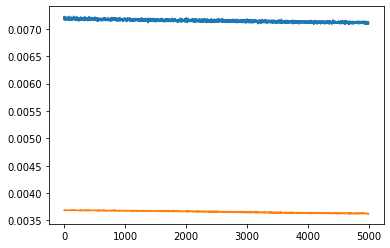

In [266]:
plt.plot((history.history['loss']))
plt.plot((history.history['val_loss']))

In [267]:
preds = model.predict(X_test)

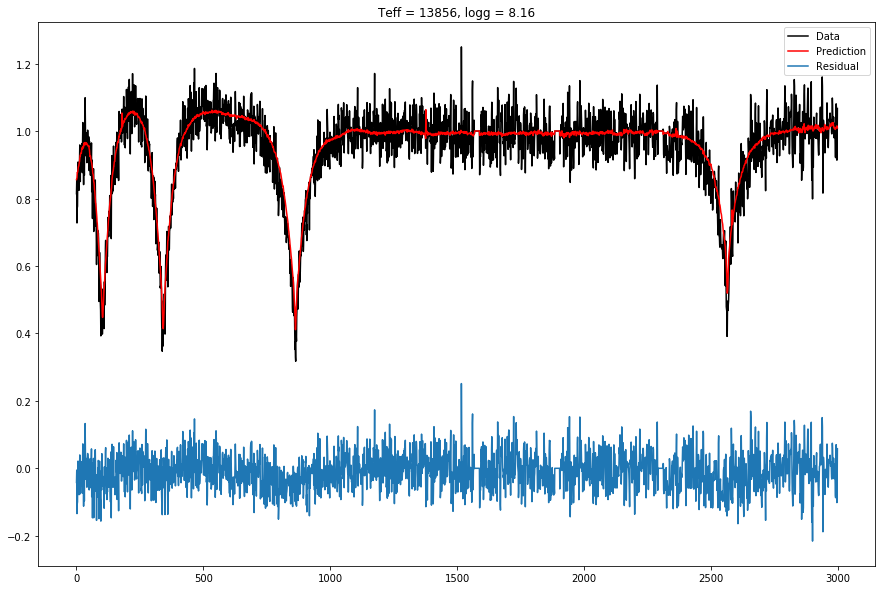

In [274]:
plt.figure(figsize=(15,10))
i = np.random.randint(len(X_test))
plt.plot(y_test[i],label='Data',color='k')
plt.plot(preds[i],label='Prediction',color='r')
plt.plot(y_test[i]-preds[i],label='Residual')
error = np.sqrt(np.sum((y_test[i]-preds[i])**2/len(y_test[i])))
labels = sc.inverse_transform(X_test)[i]
plt.title('Teff = %i, logg = %.2f'%(labels[0],labels[1]));
plt.legend()

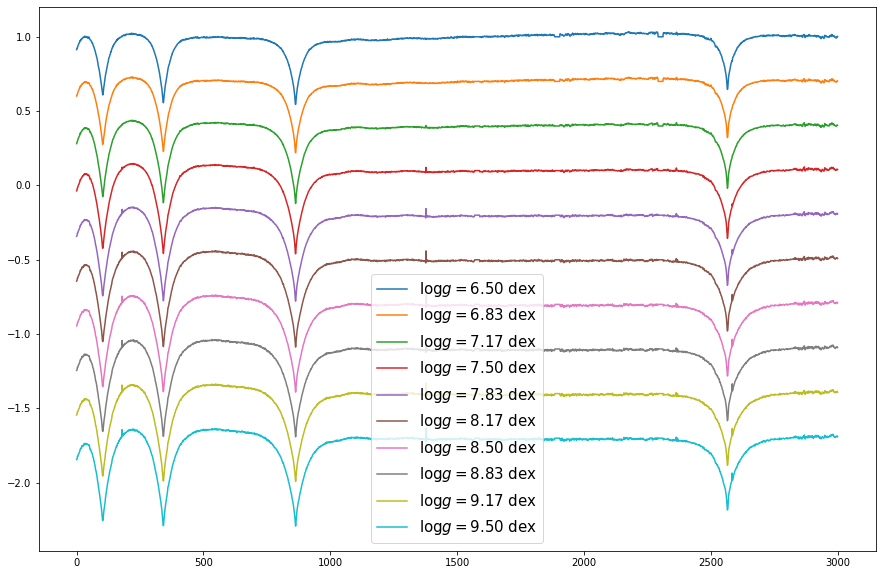

In [275]:
plt.figure(figsize=(15,10))
ts = np.linspace(15000,15000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    plt.plot(gens[i]-0.3*i,label='$\log{g} = %.2f$ dex'%ls[i])

plt.legend(fontsize=15,loc='lower center')

Text(0.5, 1.0, 'H-Alpha Line')

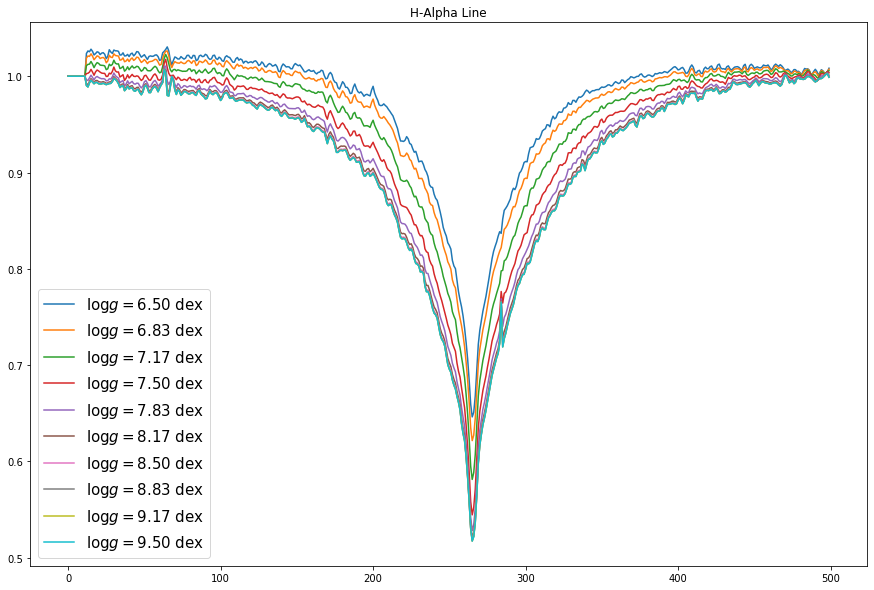

In [276]:
plt.figure(figsize=(15,10))
ts = np.linspace(15000,15000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    plt.plot(gens[i][2300:2800],label='$\log{g} = %.2f$ dex'%ls[i])

plt.legend(fontsize=15)
plt.title('H-Alpha Line')

Text(0.5, 1.0, 'H-Beta Line')

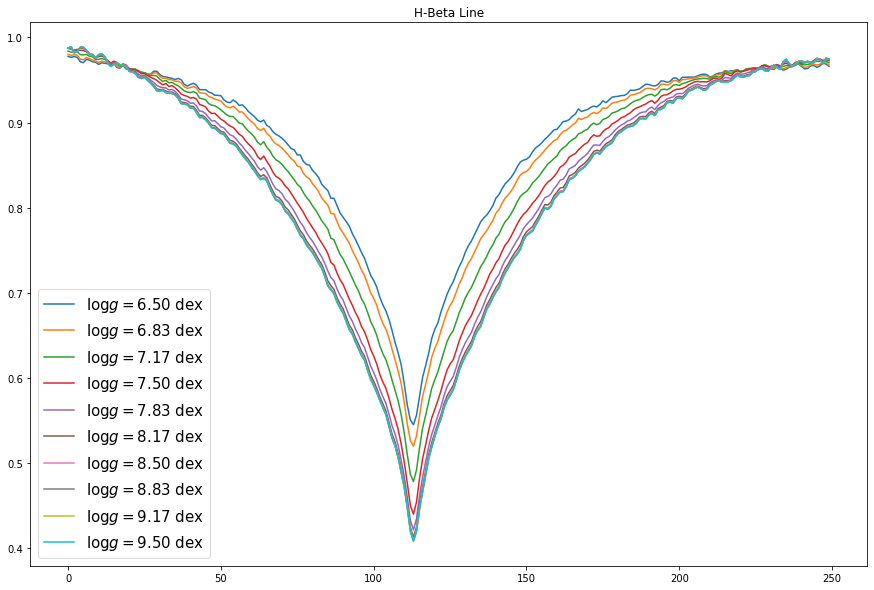

In [277]:
plt.figure(figsize=(15,10))
ts = np.linspace(15000,15000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$\log{g} = %.2f$ dex'%ls[i])

plt.legend(fontsize=15)
plt.title('H-Beta Line')

Text(0.5, 1.0, 'H-Gamma Line')

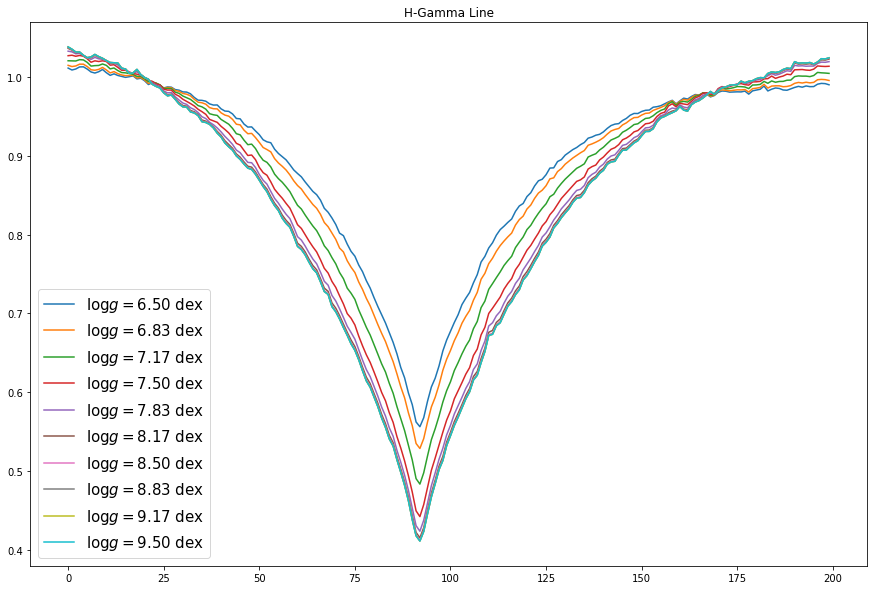

In [278]:
plt.figure(figsize=(15,10))
ts = np.linspace(15000,15000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    plt.plot(gens[i][250:450],label='$\log{g} = %.2f$ dex'%ls[i])

plt.legend(fontsize=15)
plt.title('H-Gamma Line')

Text(0.5, 1.0, 'H-Delta Line')

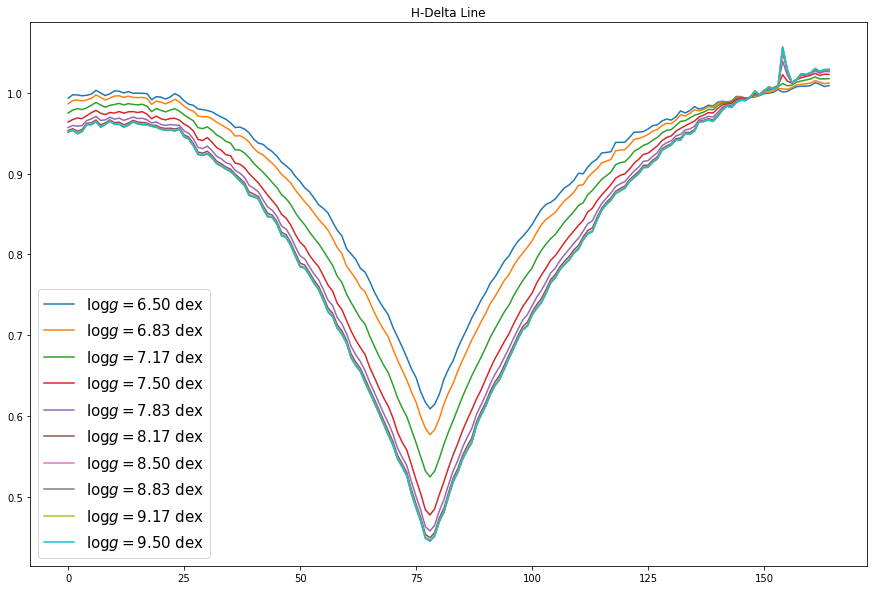

In [279]:
plt.figure(figsize=(15,10))
ts = np.linspace(15000,15000,10)
ls = np.linspace(6.5,9.5,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
for i in range(len(gens)):
    plt.plot(gens[i][25:190],label='$\log{g} = %.2f$ dex'%ls[i])

plt.legend(fontsize=15)
plt.title('H-Delta Line')

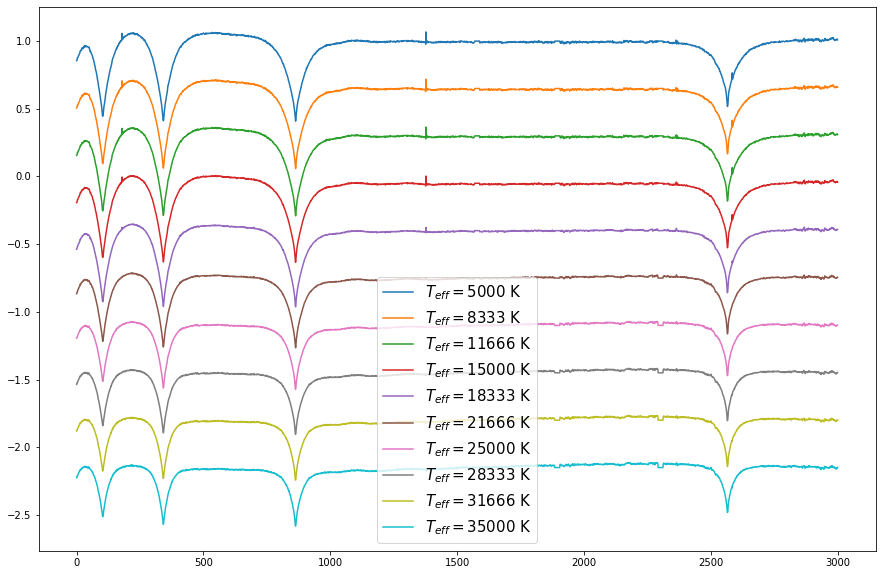

In [280]:
plt.figure(figsize=(15,10))
ts = np.linspace(5000,35000,10)
ls = np.linspace(8,8,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i]-0.35*i,label='$T_{eff} = %i$ K'%ts[i])
plt.legend(fontsize=15,loc='lower center')

Text(0.5, 1.0, 'H-Beta Line')

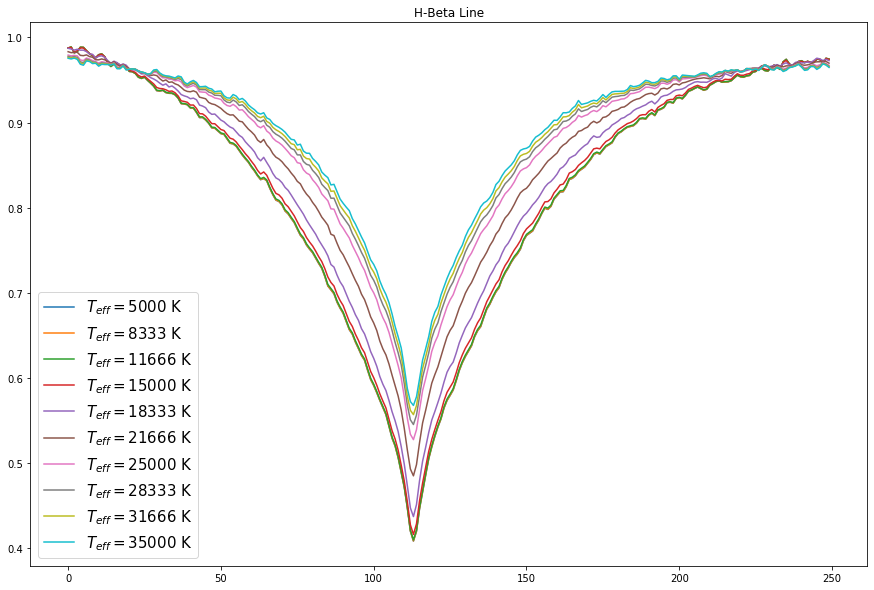

In [281]:
plt.figure(figsize=(15,10))
ts = np.linspace(5000,35000,10)
ls = np.linspace(8,8,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = model.predict(samples)
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$T_{eff} = %i$ K'%ts[i])
plt.legend(fontsize=15)
plt.title('H-Beta Line')

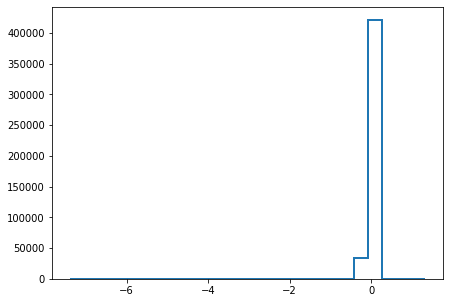

In [282]:
plt.figure(figsize=(7,5))
plt.hist(np.ravel(preds - y_test),bins = 25, histtype='step',linewidth = 2);

In [283]:
resids = y_test - preds

Text(0.5, 1.0, 'Sample of Model Residuals')

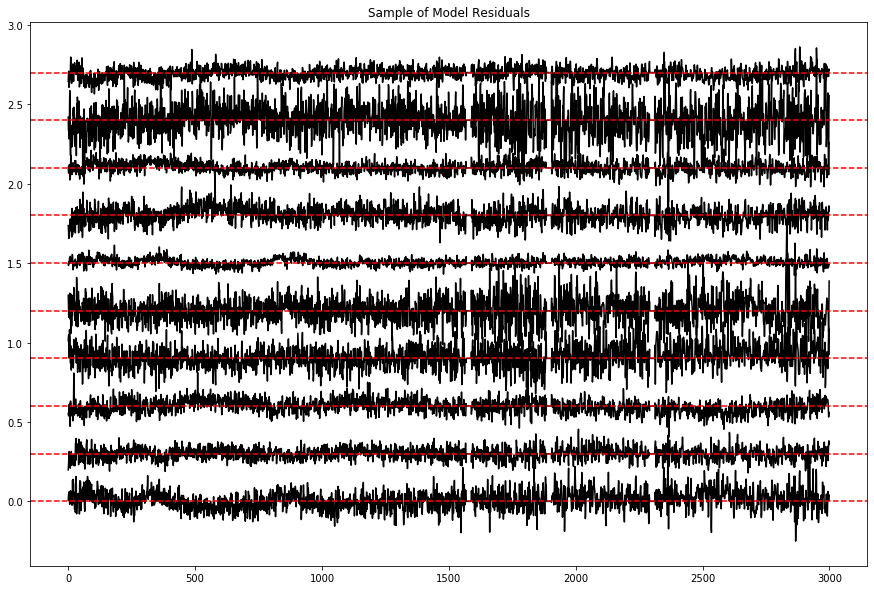

In [286]:
plt.figure(figsize=(15,10))
ct=0
for i in np.random.randint(0,len(resids),10):
    plt.plot(resids[i] + 0.3*ct,'k')
    plt.axhline(0.3*ct,color='r',linestyle='--')
    ct += 1
plt.title('Sample of Model Residuals')

# Reverse

In [292]:
sc = MinMaxScaler()

cropped = normspec[:,:]


X = (cropped - np.min(cropped)) / (np.max(cropped)-np.min(cropped))
t = sc.fit_transform(np.stack((TeffHs,loggHs)).transpose())

In [293]:
X_train,X_test,y_train,y_test = train_test_split(X,t,test_size=0.1)

In [317]:
def generator():
    x = Input(shape=X[0].shape)
    y = Dense(128,activation='sigmoid')(x)
    y = Dense(128,activation='sigmoid')(y)
    out = Dense(2,activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.1), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model

In [318]:
model = generator()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3000)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 128)               384128    
_________________________________________________________________
dense_77 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_78 (Dense)             (None, 2)                 258       
Total params: 400,898
Trainable params: 400,898
Non-trainable params: 0
_________________________________________________________________
None


In [319]:
epoch = 1000
batch = 64

history = model.fit(X_train,y_train,epochs=epoch,verbose=1,batch_size=batch,validation_data = (X_test,y_test))

Train on 1391 samples, validate on 155 samples
Epoch 1/1000
1391/1391 [==============================] - 1s 879us/step - loss: 7.3464 - mean_absolute_percentage_error: 3609432.6350 - val_loss: 1.9212 - val_mean_absolute_percentage_error: 478.9473
Epoch 2/1000
1391/1391 [==============================] - 0s 96us/step - loss: 0.5976 - mean_absolute_percentage_error: 195481.5083 - val_loss: 0.2448 - val_mean_absolute_percentage_error: 151.6847
Epoch 3/1000
1391/1391 [==============================] - 0s 92us/step - loss: 0.0839 - mean_absolute_percentage_error: 550773.9251 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 54.5651
Epoch 4/1000
1391/1391 [==============================] - 0s 93us/step - loss: 0.0211 - mean_absolute_percentage_error: 481660.0388 - val_loss: 0.0171 - val_mean_absolute_percentage_error: 91.0447
Epoch 5/1000
1391/1391 [==============================] - 0s 92us/step - loss: 0.0162 - mean_absolute_percentage_error: 420215.7960 - val_loss: 0.0126 - val_mean

1391/1391 [==============================] - 0s 89us/step - loss: 0.0185 - mean_absolute_percentage_error: 451071.8554 - val_loss: 0.0423 - val_mean_absolute_percentage_error: 186.6917
Epoch 84/1000
1391/1391 [==============================] - 0s 87us/step - loss: 0.0306 - mean_absolute_percentage_error: 476804.0918 - val_loss: 0.0131 - val_mean_absolute_percentage_error: 62.0898
Epoch 85/1000
1391/1391 [==============================] - 0s 88us/step - loss: 0.0274 - mean_absolute_percentage_error: 396205.6691 - val_loss: 0.0313 - val_mean_absolute_percentage_error: 52.1471
Epoch 86/1000
1391/1391 [==============================] - 0s 89us/step - loss: 0.0185 - mean_absolute_percentage_error: 428303.8518 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 113.4437
Epoch 87/1000
1391/1391 [==============================] - 0s 88us/step - loss: 0.0241 - mean_absolute_percentage_error: 469701.0711 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 150.8574
Epoch 88/1000
1391/13

KeyboardInterrupt: 

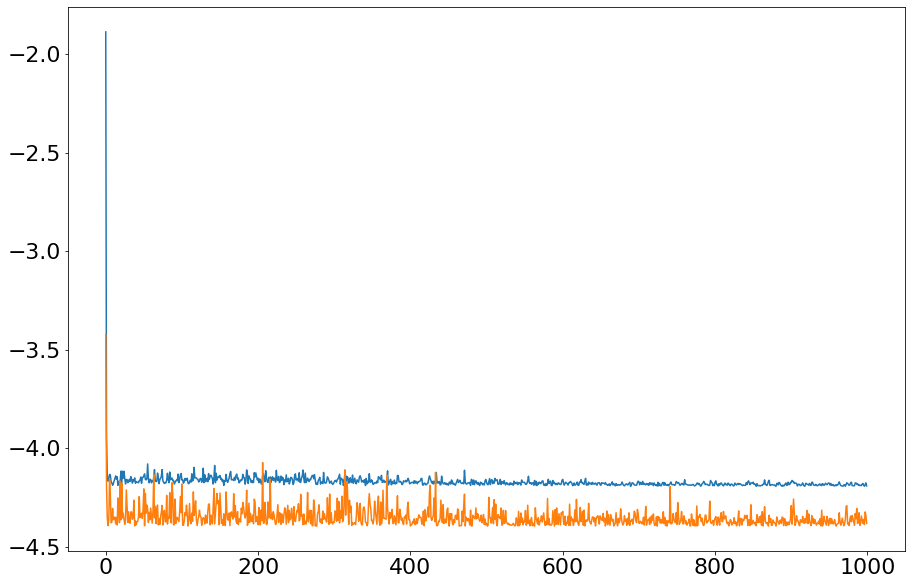

In [320]:
plt.plot(np.log(history.history['loss']))
plt.plot(np.log(history.history['val_loss']))

In [321]:
preds = sc.inverse_transform(model.predict(X_train))
reals = sc.inverse_transform(y_train)

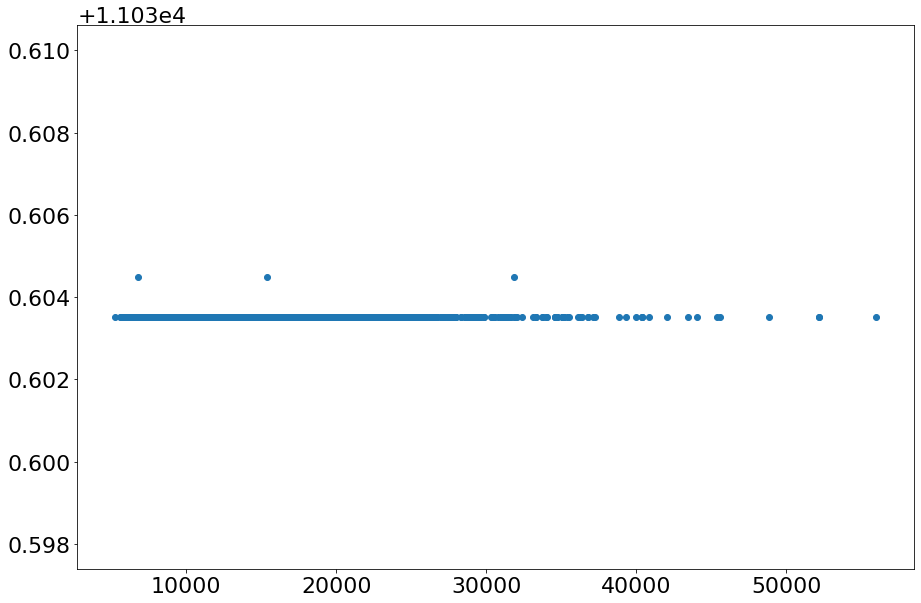

In [322]:
plt.scatter(reals[:,0],preds[:,0])

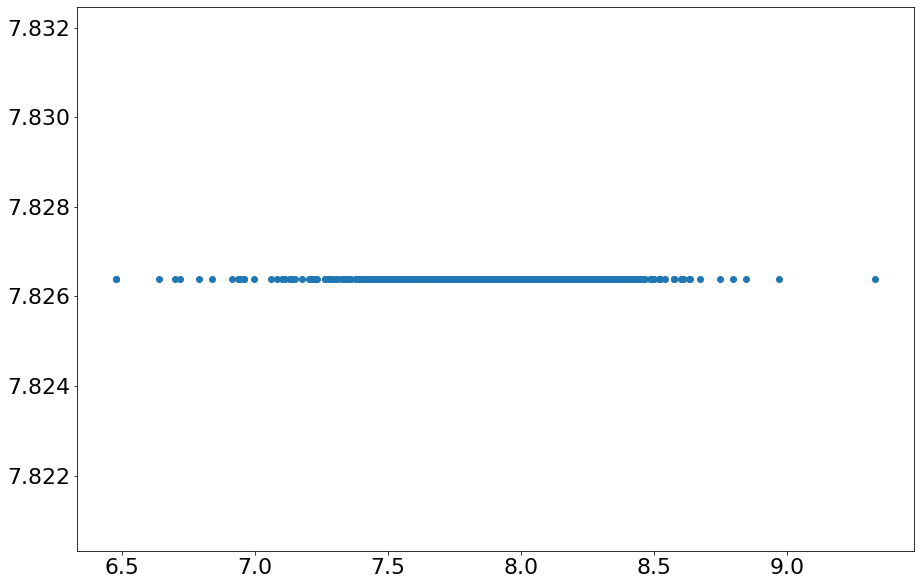

In [323]:
plt.scatter(reals[:,1],preds[:,1])

RMSE: 0.139
Error < 0.5 dex: 98.71 percent of the time.
Correlation: 0.315
RMSE: 0.075
Error < 1000 Kelvin: 100.00 percent of the time.
Correlation: 0.079


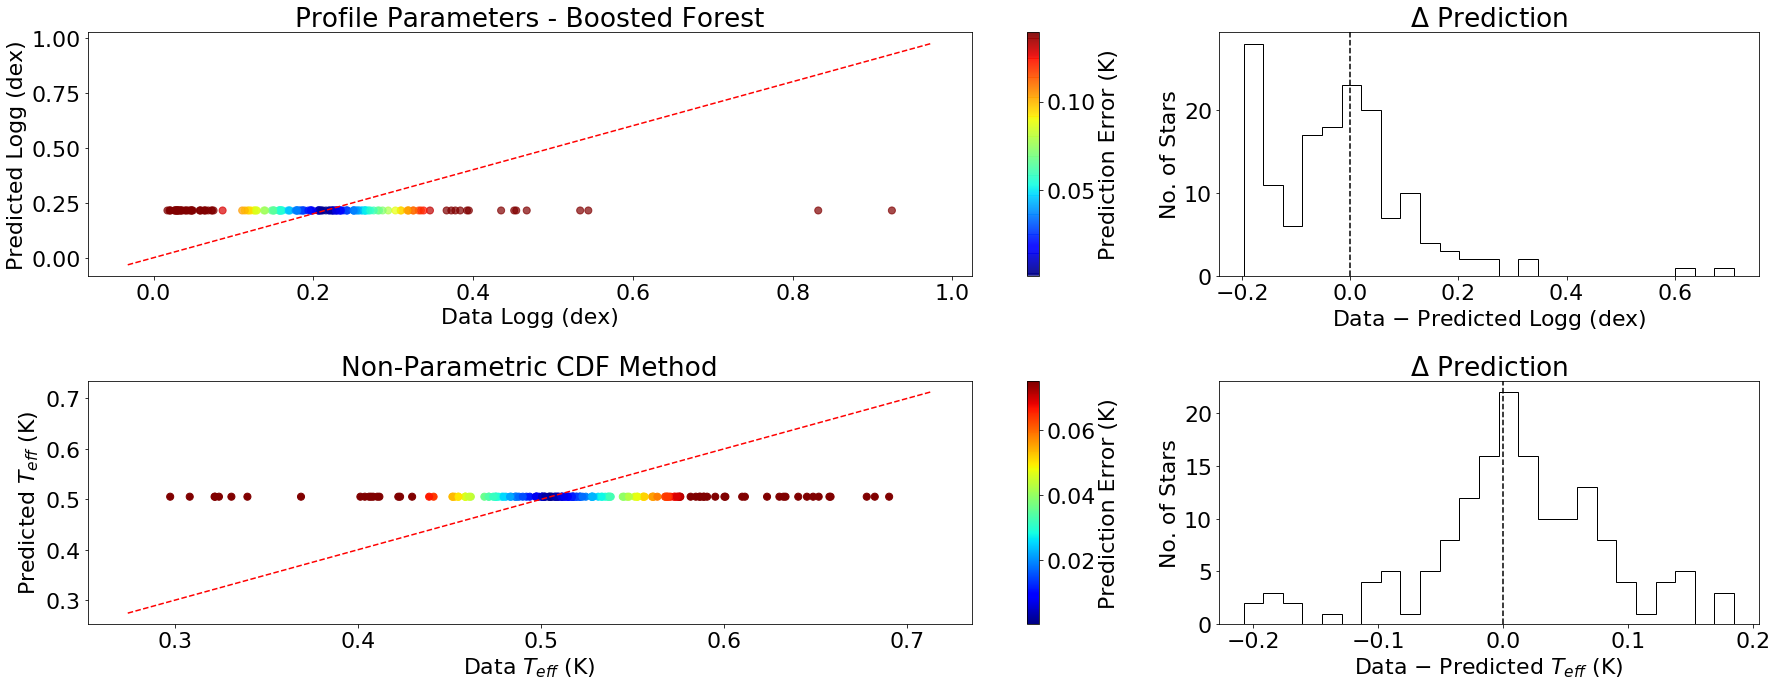

In [316]:
from matplotlib.pyplot import GridSpec

predictions = model.predict(X_test)


RMSE = np.sqrt( sum(((y_test[:,0]-predictions[:,0])**2)) / (len(y_test[:,0])))
fig = plt.figure(figsize=(25,10))
gs = GridSpec(2, 3, figure=fig)
fig.add_subplot(gs[0,0:2])
f=plt.scatter(y_test[:,0],predictions[:,0],c=np.abs(predictions[:,0]-y_test[:,0]),cmap='jet',vmax=RMSE,s=50,alpha=0.7)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Prediction Error (K)')
plt.xlabel('Data Logg (dex)')
plt.ylabel('Predicted Logg (dex)')
plt.title('Profile Parameters - Boosted Forest')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

fig.add_subplot(gs[0,2])


plt.hist(y_test[:,0]-predictions[:,0],bins=25,histtype='step',color='k');
plt.axvline(x=0,color='k',linestyle='--')
plt.title('$\Delta$ Prediction')
plt.xlabel('Data $-$ Predicted Logg (dex)')
plt.ylabel('No. of Stars');
plt.tight_layout()

print('RMSE: %.3f'%RMSE)

print('Error < 0.5 dex: %.2f percent of the time.'\
%(100-(sum(abs(y_test[:,0]-predictions[:,0])>0.5))*100/len(y_test[:,0])))
plt.rcParams.update({'font.size': 22})

print('Correlation: %.3f'%np.corrcoef(y_test[:,0],predictions[:,0])[0,1])

RMSE = np.sqrt( sum(((y_test[:,1]-predictions[:,1])**2)) / (len(y_test[:,1])))
fig.add_subplot(gs[1,0:2])
#plt.errorbar(y_test[:,1],predictions[:,1],yerr=sigmas,linestyle="None",ecolor='k',marker="None", zorder=1)
f=plt.scatter(y_test[:,1],predictions[:,1],c=np.abs(predictions[:,1]-y_test[:,1]),cmap='jet',vmax=RMSE,s=50,zorder=2)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Prediction Error (K)')
plt.xlabel('Data $T_{eff}$ (K)')
plt.ylabel('Predicted $T_{eff}$ (K)')
plt.title('Non-Parametric CDF Method')
x = np.linspace(f.axes.get_xlim()[0],f.axes.get_xlim()[1],1000)
y = x
plt.plot(x,y,'r--')

fig.add_subplot(gs[1,2])


plt.hist(y_test[:,1]-predictions[:,1],bins=25,histtype='step',color='k');
plt.axvline(x=0,color='k',linestyle='--')
plt.title('$\Delta$ Prediction')
plt.xlabel('Data $-$ Predicted $T_{eff}$ (K)')
plt.ylabel('No. of Stars');
plt.tight_layout()

print('RMSE: %.3f'%RMSE)

print('Error < 1000 Kelvin: %.2f percent of the time.'\
%(100-(sum(abs(y_test[:,1]-predictions[:,1])>1000))*100/len(t)))
print('Correlation: %.3f'%np.corrcoef(y_test[:,1],predictions[:,1])[0,1])